In [1]:
import KGInt as kg
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
from ipyparallel import Client
from operator import concat
from functools import reduce

%matplotlib inline

In [2]:
alphai = 337

f = h5.File("Levy.h5", "r")

limits = f["limits"][str(alphai)].value
alphas = np.linspace(f["alphas"]["min_alpha"].value,f["alphas"]["max_alpha"].value, f["alphas"]["length"].value)
dr     = f["dr"][str(alphai)].value

alphas[alphai]

1.0056686686686687

In [3]:
def integrate(params):
    d = "/gpfs/mnt/gpfs02/phenix/plhf/plhf1/abagoly/workdir/HBTCoulombCorrection"
    import sys
    sys.path.append(d)
    import KGInt as kg
    import numpy as np
    import h5py as h5
    
    f = h5.File(d+"/Levy.h5", "r")

    alphai = 634
    
    limits = f["limits"][str(alphai)].value
    alphas = np.linspace(f["alphas"]["min_alpha"].value,f["alphas"]["max_alpha"].value, f["alphas"]["length"].value)
    dr     = f["dr"][str(alphai)].value
    
    l=kg.Levyd(1., alphas[alphai], limits[0], limits[1], dr, f["Lr"][str(alphai)].value, 1e-8)
    c = kg.Coulomb2d(l)
        
    res = []
    for par in params:
        c.set_R(par[1])
        res.append(c.integrate(par[0],100000000))
    return res
    
def integrate3(params):
    d = "/gpfs/mnt/gpfs02/phenix/plhf/plhf1/abagoly/workdir/HBTCoulombCorrection"
    import sys
    sys.path.append(d)
    import KGInt as kg
    import numpy as np
    import h5py as h5
    
    f = h5.File(d+"/Levy.h5", "r")

    alphai = 734
    
    limits = f["limits"][str(alphai)].value
    alphas = np.linspace(f["alphas"]["min_alpha"].value,f["alphas"]["max_alpha"].value, f["alphas"]["length"].value)
    dr     = f["dr"][str(alphai)].value
    
    l=kg.Levyd(1., alphas[alphai], limits[0], limits[1], dr, f["Lr"][str(alphai)].value, 1e-8)
    c = kg.Coulomb2d(l)
        
    res = []
    for par in params:
        c.set_R(par[1])
        res.append(c.integrate(par[0],100000000))
    return res

def integrate2(params):
    d = "/gpfs/mnt/gpfs02/phenix/plhf/plhf1/abagoly/workdir/HBTCoulombCorrection"
    import sys
    sys.path.append(d)
    import KGInt as kg
    import numpy as np
    import h5py as h5
    
    f = h5.File(d+"/Levy.h5", "r")
    
    res = []
    for par in params:
        alphai = par[2]
        limits = f["limits"][str(alphai)].value
        alphas = np.linspace(f["alphas"]["min_alpha"].value,f["alphas"]["max_alpha"].value, f["alphas"]["length"].value)
        dr     = f["dr"][str(alphai)].value
    
        l=kg.Levyd(1., alphas[alphai], limits[0], limits[1], dr, f["Lr"][str(alphai)].value, 1e-8)
        c = kg.Coulomb2d(l)
        c.set_R(par[1])
        res.append(c.integrate(par[0],100000000))
    return res

In [24]:
client = Client(profile="condor", timeout=300)
dv = client[:]

In [25]:
len(client.ids)

134

In [26]:
N       = 2*134
workers = len(client.ids)

if np.ceil(N/workers)!=np.floor(N/workers):
    print("number of nodes not compatible with the workers")

In [27]:
#hosszu futasnal 130 volt, es 81*3

In [28]:
ks = np.concatenate((np.linspace(1.5, 15, 130), np.linspace(15,40, N-130)))

In [29]:
asi=[999, 867, 734, 605,467,337]
res = []
for ai in asi:
    data = list(zip(*[iter(list(zip(ks, [4*2**(1./alphas[alphai])]*len(ks), [ai]*len(ks))))]*int(N/workers)))
    res.append(dv.map_async(integrate2, data))

In [52]:
Rs = [2,4,6,8,10]
res = []
for R in Rs:
    data = list(zip(*[iter(list(zip(ks, [R*2**(1./alphas[alphai])]*len(ks))))]*int(N/workers)))
    res.append(dv.map_async(integrate, data))

In [ ]:
#1634 

In [30]:
client.wait_interactive()

 804/804 tasks finished after 1670 s
done


In [31]:
C2 = []
for r in res:
     C2.append(np.array( reduce(concat,r.get()) ))

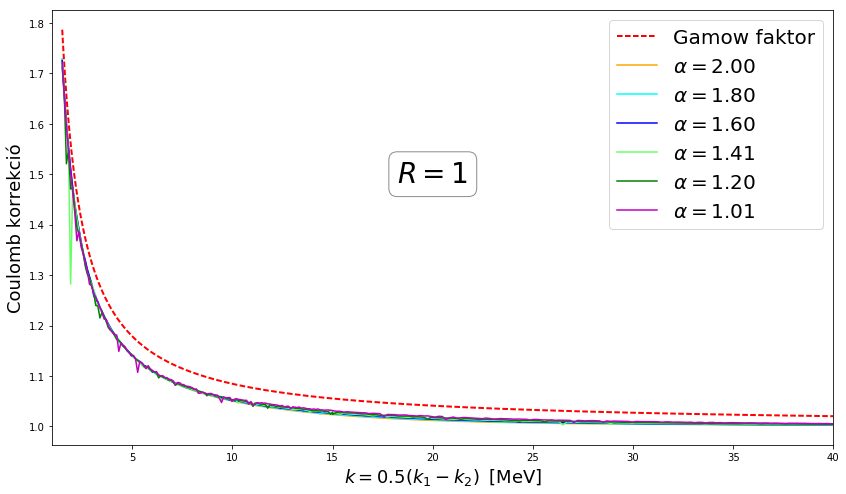

In [32]:
plt.figure(0, (14,8))
plt.xlim([1,40])
#plt.yscale("log")
plt.xlabel(r"$k = 0.5(k_1-k_2)\;\;[\mathrm{MeV}]$", fontsize=18)
plt.ylabel("Coulomb korrekció", fontsize=18)

#ks = [float(i)/6. for i in range(6,len(C[0])+6)]

kst = np.linspace(ks[0], ks[-1],1000)
eta = 0.25*139.5701835/137.0359917 / kst;
N2 = 2*np.pi*eta/(np.exp(2*np.pi*eta)-1)
plt.plot(kst, 1./N2, '--', c="red", lw=2, label="Gamow faktor")

colors = ["orange", "cyan", "blue", "#66ff66", "green", "m"]

for i in range(len(C2)):
    plt.plot(ks, C2[i], "-", c=colors[i], label=r"$\alpha=%.2f$"%alphas[asi[i]])

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
plt.text(20, 1.5, r"$R=1$", ha="center", va="center", size=28,
        bbox=bbox_props)


plt.legend(fontsize=20)
#plt.savefig("C2_dqlpha_R1_S2correct.pdf")

In [189]:
remove=[42]
for i in range(len(C)):
    C[i] = np.delete(C[i], remove)
ks = np.delete(ks,remove)

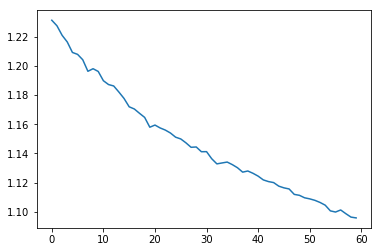

In [190]:
plt.plot(C[2][40:100])

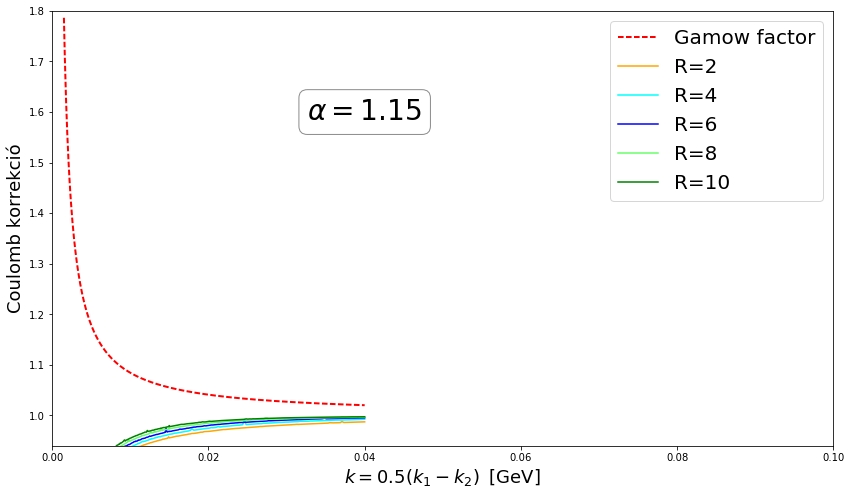

In [35]:
plt.figure(0, (14,8))
plt.xlim([0,0.1])
plt.ylim([0.94, 1.8])
#plt.yscale("log")
plt.xlabel(r"$k = 0.5(k_1-k_2)\;\;[\mathrm{GeV}]$", fontsize=18)
plt.ylabel("Coulomb korrekció", fontsize=18)

#ks = [float(i)/6. for i in range(6,len(C[0])+6)]
#ks = np.concatenate((np.linspace(1.48, 10, 400), np.linspace(10,40, len(C2[0])-400)))

kst = np.linspace(ks[0], ks[-1],1000)
eta = 0.25*139.5701835/137.0359917 / kst;
N2 = 2*np.pi*eta/(np.exp(2*np.pi*eta)-1)
plt.plot(kst/1000, 1./N2, '--', c="red", lw=2, label="Gamow factor")

colors = ["orange", "cyan", "blue", "#66ff66", "green"]

for i in range(len(C)):
    plt.plot( ks/1000, 1./C[i], "-", c=colors[i], label="R=%d"%Rs[i])

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
plt.text(0.04, 1.6, r"$\alpha=1.15$", ha="center", va="center", size=28,
        bbox=bbox_props)


plt.legend(fontsize=20)

#plt.savefig("/direct/phenix+WWW/p/draft/abagoly/CC/coulcorr_varRalpha.png",  bbox_inches='tight')
#plt.savefig("/direct/phenix+WWW/p/draft/abagoly/CC/coulcorr_varRalpha.pdf",  bbox_inches='tight')

In [378]:
1/C[0][0]

1.2105360032670311

In [292]:
C2 = []
for r in res:
     C2.append(np.array( reduce(concat,r.get()) ))

NameError: name 'C2' is not defined

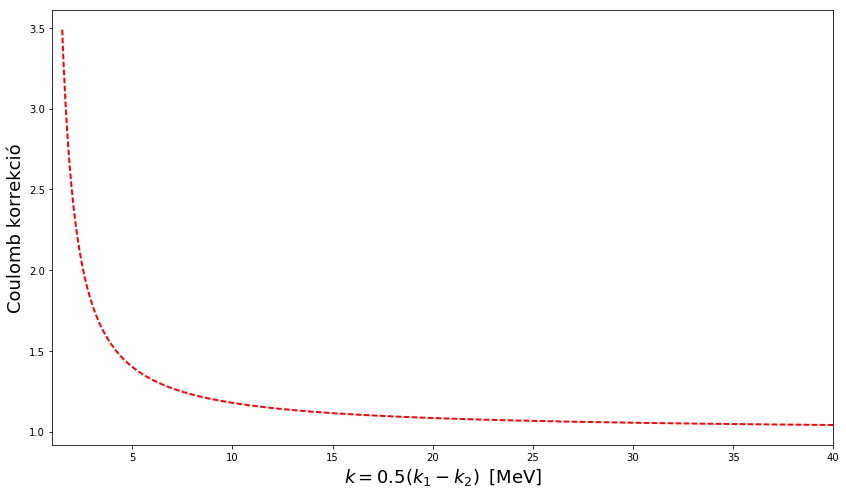

In [20]:
plt.figure(0, (14,8))
plt.xlim([1,40])
#plt.yscale("log")
plt.xlabel(r"$k = 0.5(k_1-k_2)\;\;[\mathrm{MeV}]$", fontsize=18)
plt.ylabel("Coulomb korrekció", fontsize=18)

#ks = [float(i)/6. for i in range(6,len(C[0])+6)]

kst = np.linspace(ks[0], ks[-1],1000)
eta = 0.5*139.5701835/137.0359917 / kst;
N2 = 2*np.pi*eta/(np.exp(2*np.pi*eta)-1)
plt.plot(kst, 1./N2, '--', c="red", lw=2, label="Gamow factor")

colors = ["orange", "cyan", "blue", "#66ff66", "green", "m"]

for i in range(len(C2)):
    plt.plot(ks, 1./C2[i], "-", c=colors[i], label=r"$\alpha=%.1f$"%alphas[asi[i]])

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
plt.text(20, 1.5, r"$R=4$", ha="center", va="center", size=28,
        bbox=bbox_props)

plt.legend(fontsize=20)